# Practical Session 5 - Parallel Markov chains with multiprocessing and dask

Students (pair):
- [DELANNOY Rosalie]([link](https://github.com/username1))
- [DOS RAMOS Carl]([link](https://github.com/username2))


**Useful references for this lab**:

[1] `seaborn`: [official tutorial](https://seaborn.pydata.org/tutorial.html)

[2] `multiprocessing`: [documentation](https://docs.python.org/3/library/multiprocessing.html), [doc2](https://he-arc.github.io/livre-python/multiprocessing/index.html)

[3] `dask`: [documentation](http://numba.pydata.org/) 

## <a name="content">Contents</a>
- [Exercise 1: seaborn, a useful tool for data visualisation](#ex1)
- [Exercise 2: Simulating a discrete-time homogeneous Markov chain](#ex2)
- [Bonus: Parallel computing with Dask](#bonus)
---

In [2]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: seaborn, a useful tool for data visualisation</a> [(&#8593;)](#content)
 
The `seaborn` package can significantly enhance data and data analysis visualization. See the [tutorial page](https://seaborn.pydata.org/tutorial.html) for examples of effective predefined graphics. An example aimed at visualizing the empirical distributions of 9 realizations of a bivariate Gaussian random vector is reported below.

C:\Users\rosal\AppData\Local\Temp\ipykernel_12660\1573286285.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
C:\Users\rosal\AppData\Local\Temp\ipykernel_12660\1573286285.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
C:\Users\rosal\AppData\Local\Temp\ipykernel_12660\1573286285.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
C:\Users\rosal\AppData\Local\Temp\ipykernel_12660\1573286285.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=

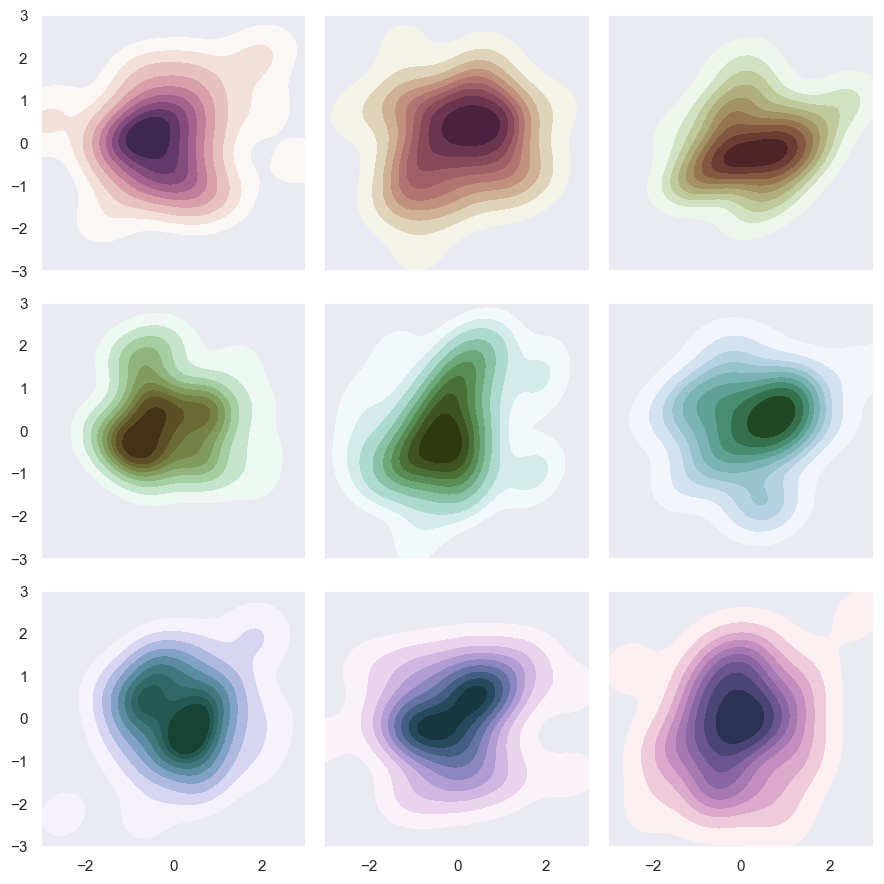

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="dark")
rng = np.random.default_rng(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rng.normal(size=(2, 50))
    sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

1. Comment on the lines of codes related to the `seaborn` library to make their role explicit. More specifically comment on the KDE method.

<div style="background-color: #333333; color: #ffffff; padding: 10px; border-radius: 5px;">
  <p><strong>Seaborn</strong> fixe un style global cohérent via <code>sns.set(style="dark")</code>, ce qui applique immédiatement un thème préconfiguré à toutes les figures de la session.</p>
  <p><code>sns.cubehelix_palette(...)</code> génère une palette continue perceptuellement uniforme ; on la passe à chaque sous-graphe pour lisser les variations de densité et conserver un contraste lisible.</p>
  <p><code>sns.kdeplot(...)</code> calcule une estimation de densité par noyau (KDE) : chaque échantillon est remplacé par un noyau gaussien, les noyaux sont sommés puis normalisés pour produire une surface lisse. Les options <code>fill=True</code> et <code>cut=5</code> remplissent les niveaux de densité et étendent légèrement la grille pour éviter les bords abrupts.</p>
  <p>Ces appels rendent la comparaison visuelle des neuf réalisations beaucoup plus riche qu'un simple nuage de points en mettant en évidence les zones de forte probabilité.</p>
</div>


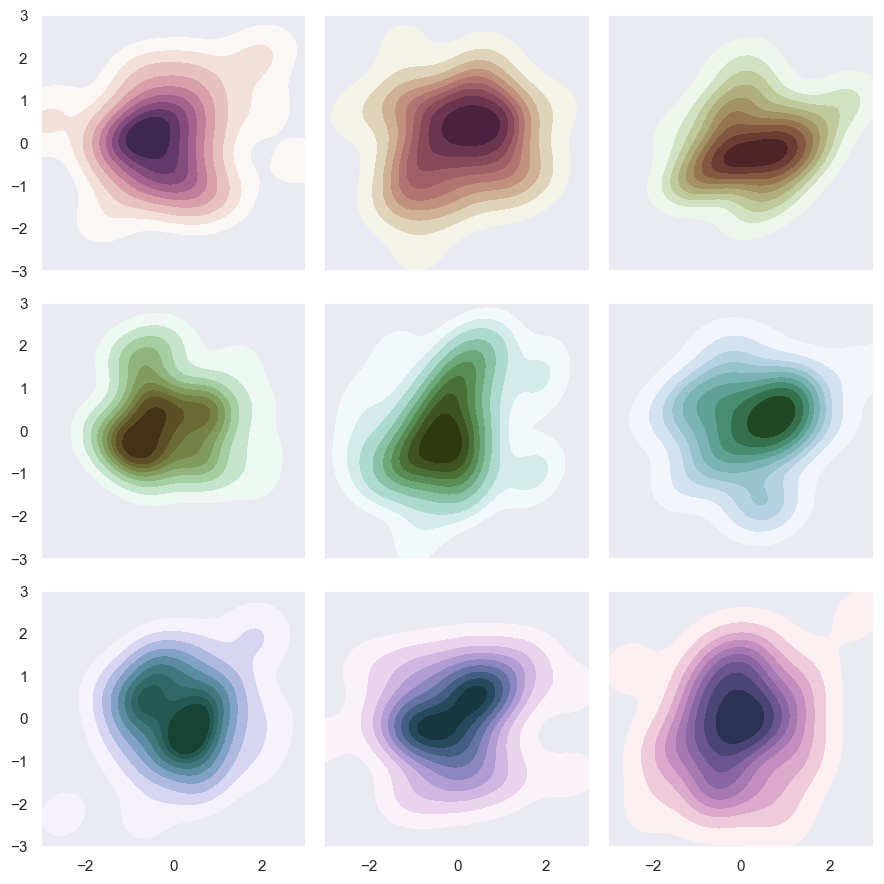

In [4]:
# On a remplacé shade par fill d'après les messages du code précédent

sns.set(style="dark") # Thème sombre pour l'ensemble des tracés
rng = np.random.default_rng(50) # Générateur fixé pour obtenir les mêmes nuages à chaque exécution

f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True) # Grille 3x3 

for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True) # Palette continue qui colore la densité
    x, y = rng.normal(size=(2, 50)) # Deux suites de gaussiennes indépendantes
    sns.kdeplot(x=x, y=y, cmap=cmap, fill=True, cut=5, ax=ax) # 'fill = True' : Remplit les zones de densité pour mieux lire la carte
    # 'cut = 5' : Étend légèrement la grille de calcul pour limiter les artefacts de bord
    ax.set(xlim=(-3, 3), ylim=(-3, 3)) # Axes cohérents

f.tight_layout()

2. For one of the realizations, take a look at the documentation of [`sns.jointplot`](https://seaborn.pydata.org/examples/joint_kde.html) to display both the 2-D empirical distribution of the data, and 1D histograms of their distribution along each axis. 

Text(0.5, 1.02, 'Distribution jointe KDE + histogrammes marginaux')

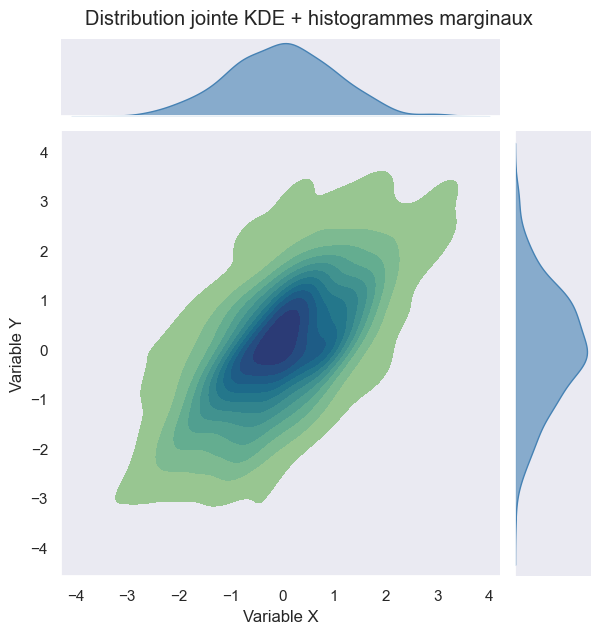

In [5]:
# Jointplot pour une réalisation unique
rng = np.random.default_rng(50)
mean = np.array([0.0, 0.0]) # Moyenne centrée en (0,0)
cov = np.array([[1.0, 0.7], [0.7, 1.4]])  # Corrélation positive modérée
samples = rng.multivariate_normal(mean, cov, size=600) # Loi normale multivariée
xx, yy = samples.T # Séparation des composantes X et Y

joint = sns.jointplot(
    x=xx,
    y=yy,
    kind="kde",  # Estimation conjointe lisse
    fill=True, # Remplit les zones de densité
    levels=12,
    cmap="crest",
    thresh=0.02, # Seuil de densité minimale pour afficher les contours
    height=6,
    marginal_kws=dict(fill=True, color="steelblue", alpha=0.6), # Paramètres pour les graphiques marginaux
)

joint.set_axis_labels("Variable X", "Variable Y", fontsize=12)
joint.fig.suptitle("Distribution jointe KDE + histogrammes marginaux", y=1.02)

## <a name="ex2">Exercise 2: Simulating a discrete-time homogeneous Markov chain.</a> [(&#8593;)](#content)


Let ${(X_n)}_{n\geq 0}$ be a discrete-time homogeneous Markov chain with values over a finite ensemble $E=\{x_1,\dots,x_N\}$ identified to $\{1,\dots,N\}$. Consider $\boldsymbol{\rho} \in \Delta_N$, where $\Delta_N = \{\mathbf{x}\in\mathbb{R}^N \mid x_n \geq 0 \, \forall n \in \{1,\dotsc,N\} \text{ and } \sum_n x_n = 1 \}$ is the unit simplex in $\mathbb{R}^N$.

In the following, we consider the initial state of the chain $X_0$, following the discrete probability distribution:

$$
    \mathbb{P}(X_0 = k) = \rho_k, \qquad k \in \{1, \dots,  N\}.
$$
  
Let $\mathbf{A} = [a_{i,j}]_{i,j} \in \mathbb{R}^{N \times N}$ be the transition matrix of the chain, i.e.,

\begin{align*}
    &a_{i,j} = \mathbb{P}(X_{n+1} = j \mid X_{n} = i) \geq 0, \, \forall n \geq 0, \\
    &(\forall i \in \{1, \dotsc, N\}), \quad \sum_{j=1}^N a_{i,j} = 1.
\end{align*}
 
The chain is said to be homogeneous in that $\mathbf{A}$ does not depend from the time index $n$. Let $\tilde{a}_n$ represent the $n$-th row of $\mathbf{A}$. 

The trajectory of the chain can be simulated as follows:

>- Draw the discrete random variable $X_0$ with distribution $\boldsymbol{\rho}$;
>
>- For $q = 0$ to $n_{\text{iter}}-1$
>    - Draw the discrete random variable $X_{q+1}$ with distribution $\tilde{a}_{X_{q}}$;
>    
>- Return ${(X_q)}_{0 \leq q \leq n_{\text{iter}}}$.


<!-- If $X_n = k$, we know that $T$, the life time of the chain in the state $k$ obeys a geometric distribution with parameter $a_{kk}$. We also know that the probability of transition from k to $\ell\neq k$ is given by:

$$
    \mathbb{P}(X_{n+1}=\ell | X_n=k, \ell\neq k) = \frac{a_{k\ell}}{1-a_{kk}}.
$$

 ### One possible algorithm to simulate a Markov chain is therefore:

    a. generate the initial state $X_0$ according to the discrete law $\{\rho_1,\dots,\rho_N\}$.

    b. at instant $n$, knowing that $X_n=k$,

    i) determine the life time $T$ in state $X_n=k$ by simulating a geometrical variable with parameter $a_{kk}$. As a consequence $X_n = \dots = X_{n+T} = k$. When $T=0$, we simply still have $X_n=k$.

    ii) determine next transition instant $n+T$, and determine the next state by using the probabilities of transition. -->

1. Implement the above algorithm in a function `X = markov(rho,A,nmax,rng)` with:
     - `rho`: law of the initial state (nonnegative vector of size $N$, summing to 1),
     - `A`: transition matrix (of size $N\times N$) 
     - `nmax`: number of time steps,
     - `rng`: random number generator
     - `X`: trajectory of the chain.
     
In particular, check the input parameters `A` and `rho` make sense by adding appropriate assertions (or raising exceptions).
   - Examples : **transition matrix `A` should be square** ; **expected `A` to be a stochastic matrix** ; **verify if the size of `A` and `rho` are consistent** ; **verify if `rho` is in the unit simplex**
     - `np.allclose`, `np.isclose` and `np.all` could be useful

> Hints:
> - the function `np.random.choice` can be useful to draw discrete random variables.
> - use `states = np.arange(N)` to create the the labels of the states (from $0$ up to $N-1$)

Here is an example of execution : 
![alternatvie text](img/For_CourseM.png)

In [6]:
from typing import Sequence

def markov(rho, A, nmax, rng):

    # Vérification des paramètres
    A = np.asarray(A, dtype=float)
    rho = np.asarray(rho, dtype=float).reshape(-1)

    N = A.shape[0] # Nombre d'états possibles

    # Vérifie que A est une matrice carrée
    assert N == A.shape[1], "Erreur : A doit être une matrice carrée."

    # Vérifie que la taille de rho est cohérente avec A
    assert rho.shape[0] == N, "Erreur : rho et A n'ont pas la même dimension."

    # Vérifie que rho est dans le simplexe (somme = 1, valeurs >= 0)
    assert np.all(rho >= 0), "Erreur : les probabilités dans rho doivent être non négatives."
    assert np.isclose(np.sum(rho), 1.0), "Erreur : la somme des probabilités de rho doit valoir 1"

    # Vérifie que chaque ligne de A est stochastique (somme = 1)
    assert np.allclose(A.sum(axis=1), 1.0), "Erreur : chaque ligne de A doit sommer à 1."
    assert np.all(A >= 0), "Erreur : les éléments de A doivent être >= 0."

    # Initialisation
    states = np.arange(N)
    trajectory = np.zeros(nmax + 1, dtype=int)

    trajectory[0] = rng.choice(states, p=rho)  # Tirage du premier état X0 selon rho

    # Simulation de la chaîne
    for step in range(nmax):
        current_state = trajectory[step]
        # Tirage du prochain état selon la ligne correspondante de A
        trajectory[step + 1] = rng.choice(states, p=A[current_state])
    return trajectory # Retour de la trajectoire complète

2. Set the random number generator to a known state. Make a few simulations using simple transition matrices (*i.e.*, taking any nonnegative matrix $A=(a_{i,j})$ such that its lines sum to 1) and display the trajectory of the chains.

Trajectoire 1 (A1) : [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2
 2 2 2 2]
Trajectoire 2 (A2) : [2 2 1 2 2 1 0 1 0 0 0 1 1 2 2 1 1 0 0 1 1 1 2 2 2 2 1 0 0 0 0 1 0 0 0 0 1
 1 2 2 1]
Trajectoire 3 (A3) : [2 0 0 0 2 1 0 1 0 2 1 1 0 1 1 0 0 2 2 2 0 2 2 2 1 0 0 2 1 0 0 1 0 2 2 2 1
 1 1 1 0]


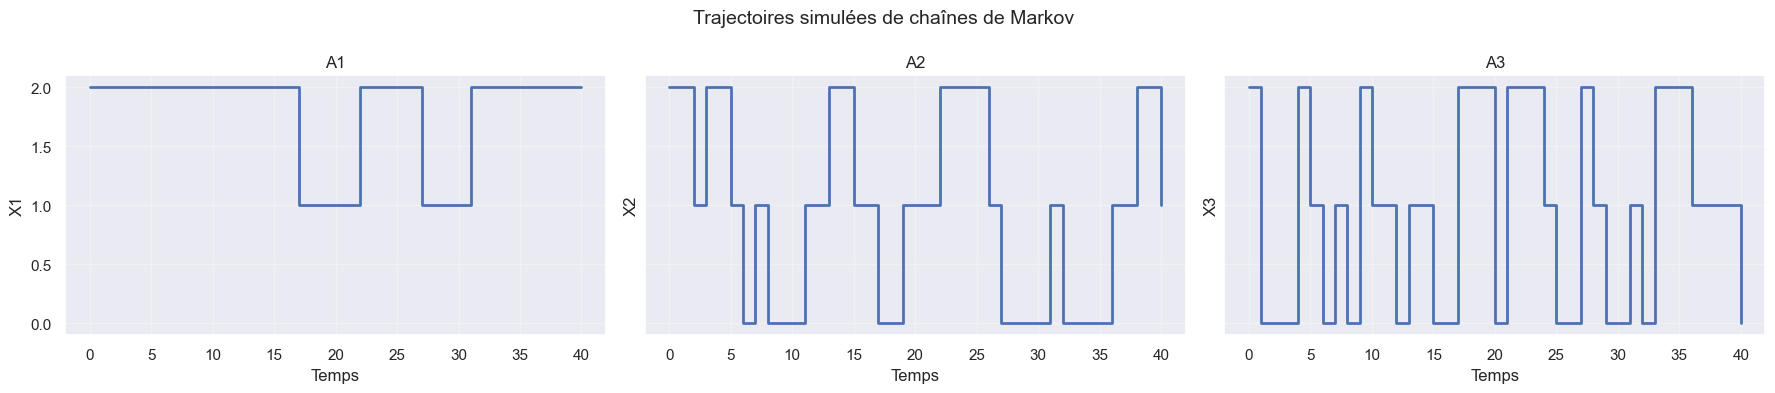


Fréquences d'occupation des états :

A1 :
 - Etat 0: 0.00
 - Etat 1: 0.22
 - Etat 2: 0.78

A2 :
 - Etat 0: 0.34
 - Etat 1: 0.37
 - Etat 2: 0.29

A3 :
 - Etat 0: 0.37
 - Etat 1: 0.32
 - Etat 2: 0.32


In [7]:
# Comparaison de trajectoires pour trois matrices de transition simples

rng = np.random.default_rng(42)
rho = np.array([1/3, 1/3, 1/3])
matrices = {
    "A1": np.array( # Chaîne à 3 états avec forte proba de rester dans le même état
        [
            [0.9, 0.05, 0.05],
            [0.1, 0.8, 0.1],
            [0.025, 0.05, 0.925]
        ]
    ),
    "A2": np.array( # Chaîne à 3 états avec transitions mélangées
        [
            [0.5, 0.4, 0.1],
            [0.3, 0.4, 0.3],
            [0.2, 0.3, 0.5]
        ]
    ), 
    "A3": np.full((3,3), 1/3) # Chaîne aléatoire
}

# Simulation de trajectoires 

n_steps = 40 # nombre d'étapes simulées

X1 = markov(rho, matrices["A1"], n_steps, rng)
X2 = markov(rho, matrices["A2"], n_steps, rng)
X3 = markov(rho, matrices["A3"], n_steps, rng)

print("Trajectoire 1 (A1) :", X1)
print("Trajectoire 2 (A2) :", X2)
print("Trajectoire 3 (A3) :", X3)

# Visualisation des trajectoires

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
occupations = {}
trajectoires = {"A1": X1, "A2": X2, "A3": X3}
noms_axes = {"A1": "X1", "A2": "X2", "A3": "X3"}

for ax, (title, traj) in zip(axes, trajectoires.items()):
    # Calcul des fréquences d'occupation
    occupations[title] = np.bincount(traj, minlength=np.max(traj)+1) / traj.size

    # Tracé de la trajectoire
    ax.step(range(traj.size), traj, where="post", linewidth=2)
    ax.set(title=title, xlabel="Temps", ylabel=noms_axes[title])
    ax.grid(True, alpha=0.3)

fig.suptitle("Trajectoires simulées de chaînes de Markov", fontsize=14)
plt.tight_layout()
plt.show()

# Affichage des fréquences d'occupation
print("\nFréquences d'occupation des états :")
for title, occ in occupations.items():
    print(f"\n{title} :")
    for i, p in enumerate(occ):
        print(f" - Etat {i}: {p:.2f}")

3. Explore the potential of the [`multiprocessing` package](https://docs.python.org/3/library/multiprocessing.html) to simulate several Markov chains in parallel.

> Hint: the `mutiprocessing.Pool.starmap` or `mutiprocessing.Pool.starmap_async` methods could be useful.

In [ ]:
from multiprocessing import Pool

if __name__ == "__main__":
    
    # Fonction wrapper pour préparer la prochaine fonction
    def simulate_chain(args):
        name, rho, A, n_steps, seed = args
        rng = np.random.default_rng(seed)
        traj = markov(rho, A, n_steps, rng)
        return name, traj

    # Préparation des arguments pour chaque simulation
    args_list = [
        ("X1", rho, matrices["A1"], n_steps, 100),
        ("X2", rho, matrices["A2"], n_steps, 100),
        ("X3", rho, matrices["A3"], n_steps, 100)
    ]

    # Simulation en parallèle
    with Pool(processes=3) as pool:
        results = pool.starmap(simulate_chain, args_list)

    # Organisation des résultats
    trajectoires = {name: traj for name, traj in results}

    # Visualisation
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

    for ax, (title, traj) in zip(axes, trajectoires.items()):
        ax.step(range(len(traj)), traj, where="post", linewidth=2)
        ax.set(title=f"Chaîne {title}", xlabel="Temps n", ylabel=title)
        ax.grid(True, alpha=0.3)

    fig.suptitle("Simulation parallèle de chaînes de Markov", fontsize=14)
    plt.tight_layout()
    plt.show()

4. [Bonus] Generate Markov chains in parallel with the [`dask`](https://docs.dask.org/en/latest/futures.html) library, which offers more general parallelization functionalities (with, for instance, the use of [`Futures`](https://docs.dask.org/en/stable/futures.html), see tutorial [here](https://tutorial.dask.org/05_futures.html)). A useful example is provided [here](https://stackoverflow.com/questions/41471248/how-to-efficiently-submit-tasks-with-large-arguments-in-dask-distributed). Note that `dask` is much more versatile and powerful than `multiprocessing`, and can be useful to scale algorithms over multiple cores and/or computing nodes.

In [ ]:

try:
    from dask.distributed import Client, LocalCluster
except ImportError as exc:
    print("Dask distributed n'est pas disponible dans cet environnement :", exc)
else:
    rho_dask = np.array([0.4, 0.4, 0.2])
    A_dask = np.array(
        [
            [0.80, 0.15, 0.05],
            [0.25, 0.60, 0.15],
            [0.10, 0.35, 0.55],
        ]
    )
    n_dask_steps, n_dask_chains = 400, 12

    cluster = LocalCluster(n_workers=2, threads_per_worker=2, dashboard_address=None)
    client = Client(cluster)

    def simulate_chain_future(seed: int) -> np.ndarray:
        rng_local = np.random.default_rng(seed)
        return markov(rho_dask, A_dask, n_dask_steps, rng_local)

    dask_seeds = np.random.SeedSequence(3030).generate_state(n_dask_chains, dtype=np.uint32)
    futures = [client.submit(simulate_chain_future, int(seed)) for seed in dask_seeds]
    chains_dask = client.gather(futures)

    chains_dask = np.asarray(chains_dask)
    avg_occupancy = np.apply_along_axis(
        lambda path: np.bincount(path, minlength=A_dask.shape[0]),
        axis=1,
        arr=chains_dask,
    ).mean(axis=0) / chains_dask.shape[1]

    print("Occupation moyenne (Dask Futures) :", np.round(avg_occupancy, 3))
    client.close()


## <a name="bonus">Bonus: Parallel computing with Dask</a> [(&#8593;)](#content)

1. Take a look at the [`dask.array` documentation](https://docs.dask.org/en/stable/array-best-practices.html) and the associate [tutorial](https://tutorial.dask.org/02_array.html). Apply some of the functions introduced herein and in the [documentation](https://docs.dask.org/en/stable/array-best-practices.html) to parallelize the computation of the total variation investigated during session 2. Note that you can combine `dask` and `numba` to obtain an overall more efficient implementation. Note that timing can be worse than Numpy (`dask.array` is more specifically interesting when the data do no fit in memory).

2. Take a look at the [`dask.delayed` tutorial](https://tutorial.dask.org/03_dask.delayed.html), and go through some of the examples provided. [Best practices with the `dask.delayed` interface](https://docs.dask.org/en/stable/delayed-best-practices.html) are summarized in the documentation.

> **Remark**: an alternative to Dask: the [Ray](https://docs.ray.io/en/latest/) library.

<div style="background-color: #333333; color: #ffffff; padding: 10px; border-radius: 5px;">
  <p>Le découpage des données en blocs (<em>chunks</em>) avec <code>dask.array</code> permet de distribuer le calcul de la variation totale sans charger l'image complète en mémoire par worker.</p>
  <p>La fonction est évaluée paresseusement : rien n'est exécuté tant que l'on n'appelle pas <code>compute()</code>, ce qui autorise l'empilement d'autres traitements (normalisation, filtrage) avant d'engager les ressources.</p>
  <p>Le couple <code>dask.delayed</code> / <code>compute</code> reste utile pour orchestrer des opérations plus hétérogènes (ex. mélange de NumPy, numba, lectures disque) tout en conservant un graphe d'exécution clair.</p>
</div>


In [ ]:

try:
    import dask.array as da
    from dask import delayed, compute
except ImportError as exc:
    print("Dask array/delayed indisponible :", exc)
else:
    rng_tv = np.random.default_rng(404)
    image = rng_tv.standard_normal((2048, 2048))

    # Version dask.array : on découpe l'image en blocs pour paralléliser les différences finies
    image_da = da.from_array(image, chunks=(512, 512))

    def total_variation_da(arr_da: da.Array) -> da.Array:
        grad_h = da.diff(arr_da, axis=1, append=arr_da[:, -1:])
        grad_v = da.diff(arr_da, axis=0, append=arr_da[-1:, :])
        return da.hypot(grad_h, grad_v).sum()

    tv_lazy = total_variation_da(image_da)
    tv_value = float(tv_lazy.compute())  # Déclenche réellement le calcul parallèle
    print(f"Total variation (dask.array) : {tv_value:.3e}")

    # Version dask.delayed : on évalue la TV bloc par bloc grâce à des tâches paresseuses
    block_size = 512
    blocks = []
    for i in range(0, image.shape[0], block_size):
        for j in range(0, image.shape[1], block_size):
            block = image[i : i + block_size, j : j + block_size]

            @delayed
            def tv_numpy_patch(patch: np.ndarray) -> float:
                grad_h_np = np.diff(patch, axis=1, append=patch[:, -1:])
                grad_v_np = np.diff(patch, axis=0, append=patch[-1:, :])
                return float(np.hypot(grad_h_np, grad_v_np).sum())

            blocks.append(tv_numpy_patch(block))

    tv_blocks = compute(*blocks)
    print(f"TV moyenne par bloc (delayed) : {np.mean(tv_blocks):.3e}")
